In [ ]:
#How to choose an appropriate Prior
#subjective vs objective priors

#objective priors aim to allow the data to influence the posterior the most
#subjective priors allow the practitioner to impute their view into priors

#We've used an objective prior already with "flat" priors
#These are uniform distributions over the entire range of unknowns
#Principle of indifference assigns equal probability to each possible value

#Rarely is an objective prior truly objective



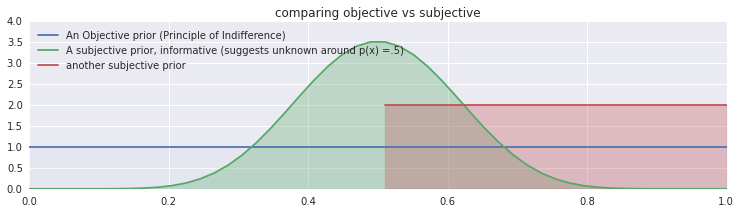

In [4]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn 

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1,y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10,10)

p = plt.plot(x,y1, label="An Objective prior (Principle of Indifference)")
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=.03)

p = plt.plot(x, y2, label="A subjective prior, informative (suggests unknown around p(x) =.5)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3 )

p = plt.plot(x[25:], 2*np.ones(25), label="another subjective prior")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)
leg = plt.legend(loc='upper left')
leg.get_frame().set_alpha(0.4)
plt.title("comparing objective vs subjective")

In [ ]:
#Subjective prior can be the result of a posterior that we use from previous iterations
#It can also be domain knowledge
#It is not necessarily opinion, it is simply prior knowledge

In [5]:
#To determine which type of prior is best, it really depends on
#the question.If the question to be answered is in the scientific 
#realm a objective prior is most appropriate.
#If, once our posterior distribution emerges, we believe that our posterir
#is inaccurate, then we did not include enough information in our prior
#In this case, we should go back and update our prior with the missing information

#Some objective priors, however, should reflect actual possible values
#Some priors may generate values in the extremes that are in fact
#not possible. This selection of a prior will not reflect the actual distribution

#Also, if we instead opt for a subjective prior, we should make it 
#obvious that we have used prior information and which information we 
#are using to inform the prior

In [6]:
#Empirical Bayes
#Uses empirical (observed data) to inform the prior
#This is a hybrid frequentist and Bayesian approach
#However, it double counts the observed data and will influence the 
#the results towards the observed data
#This has the effect of understating our uncertainty
#It is adviseable to use EB only when there are many many observations
#EB also violates a theoretical axiom of Bayesian inference
        #Theoretical: prior->observed data->posterior
        #Empirical: observed data-> prior -> observed data -> posterior

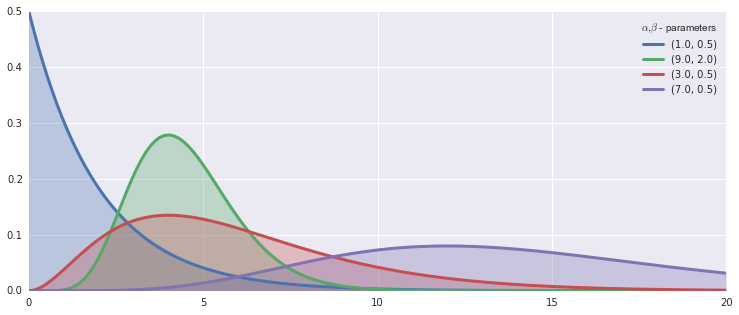

In [11]:
#When looking for useful objective priors consider these
#Gamma is a generalization of the exponential distribuion
#Adjusting the alpha, beta parameters allows the practitioner
#to inflect their views about the prior distribution

#Gamma Distribution

figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale= 1. / beta)
    lines = plt.plot(x,y, label = "(%.1f, %.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=.3, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters");

Couldn't import dot_parser, loading of dot files will not be possible.


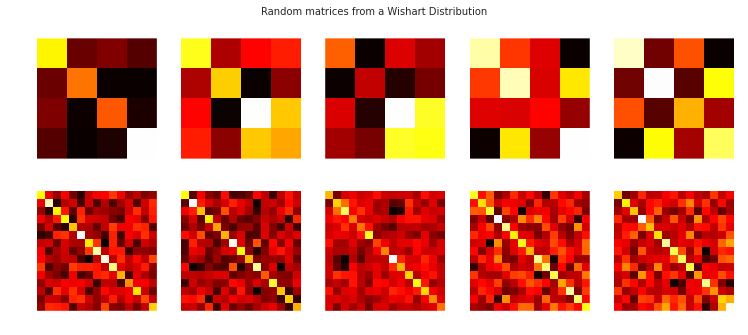

In [12]:
#The Wishart Distribution
    #distribution over all positive semi-definite matrices
    #Wishart is appropriate prior for covariance matrices
import pymc as pm


n = 4
for i in range(10):
    ax = plt.subplot(2,5,i + 1)
    if i >=5:
        n = 15
    plt.imshow(pm.rwishart(n+1, np.eye(n)), interpolation='none',
              cmap=plt.cm.hot)
    ax.axis('off')
    
plt.suptitle("Random matrices from a Wishart Distribution")

In [15]:
from pymc import rbeta

class Bandits(object):
    """
    This class represents N Bandits machines. 
    parameters: 
        p_array: a(n,) Numpy array of probabilities > 0, < 1
        
    methods: pull(i): return the results, 0 or 1, of pulling the 
                ith bandit
    """
    
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
    
    def pull(self, i):
        #i is arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

class BayesianStrategy(object):
    """
    Implements an online, learning strategy to solve MAB problem
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods: 
        sample_bandits(n): sample and train on n pulls
        
    attributes: 
        N: the cumulative number of samples
        choices: the historical choices as a (N, ) array
        bb_score: the historical score as a (N, ) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from bandit priors and select highest prior
            choice = np.argmax(rbeta(1 + self.wins, 1+self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #updata priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [22]:
#Visualizing the Bayesian Bandit Solution

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=.2, plt_vlines=True):
    
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                        colors=c, linestyles='--', lw=2)
        plt.autoscale(tight=True)
        plt.title("Posteriors After %d pull" % bayesian_strategy.N + 
                  's' *(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    
    return

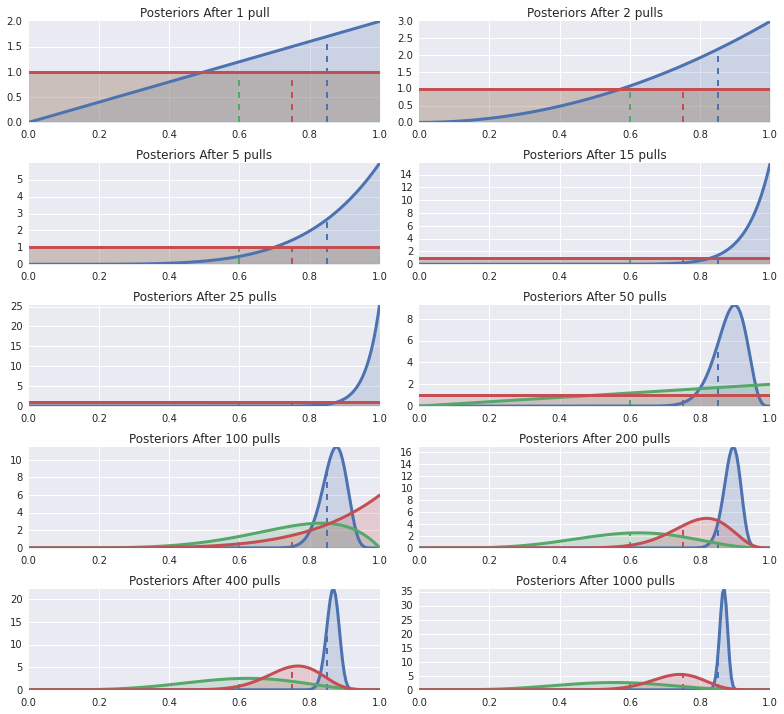

In [23]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)


draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]


for j, i in enumerate(draw_samples):
    plt.subplot(5,2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    
    plt.autoscale(tight=True)

plt.tight_layout()

In [26]:
#With this approach we don't care about the actual hidden probabilities. We are only
#concerned with the best strategy, where is the confidence in the success of the bandit highest.
#We can see that 

figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

strategies = [upper_credible_choice,
              bayesian_bandit_choice,
              ucb_bayes,
              max_mean,
              random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

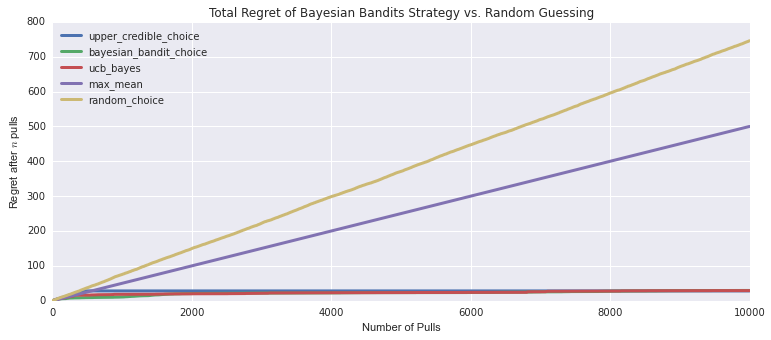

In [27]:
#train 10000 times

for strat in algos:
    strat.sample_bandits(10000)

#test and plot
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)
    
plt.title("Total Regret of Bayesian Bandits Strategy vs. Random Guessing")
plt.xlabel("Number of Pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc="upper left")

In [28]:
#We can see that random guess have a much higher regret than the Bayesian bandit Strategies
#This means we are achieving optimal choices

In [ ]:
#We should measure total expected regret and if we can run the experiment
# a large number of times we should expect to approximate the total expected regret

trials = 200
#expected_total_regret = np.zeros(1000, 3)
#Lets look at upper_credible_choice, ucb_bayes, bayesian_bandit_choices
for i_strat, strat in enumerate(strategies[:-2]):
    general_strat = GeneralBanditStrat(bandits, strat)
    general_strat.sample_bandits(1000)
    _regret = regret(hidden_prob, general_strat.choices)
    expected_total_regret[:, i_strat] += regret

plt.title("Expected Total Regret of MAB Strats")
plt.xlabel("Number of Pulls")
plt.ylabel("Expected total regret \nafter $n$ pulls")
plt.legend(loc="upper left") 

In [ ]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw=3)
plt.xscale('log')
plt.legend([pl1, pl2, pl3], 
          ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
          loc="upper left")
plt.ylabel("Expected Total Regret \n after $log{n}$ pulls");
plt.title("Log-Scale of Above")
plt.ylabel("Expected Total Regret \n after $log{n}$ pulls");


